## Hyperparamter tuning in Pytorch model

* Hyperparameter tuning is crucial for optimizing the performance of PyTorch models.
* PyTorch does not have built-in tools for hyperparameter tuning, but you can use external libraries like **`Optuna`**,**`Ray Tune`**, or **`GridSearchCV`** (from sklearn) for this purpose.
* However I find that **`optuna`** is a light-weight and flexible framework to begin with thatswhy I prefer to use it more than anyother framework

In [ ]:
# Install these if you have not
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.4 MB/s eta 0:00:00


In [ ]:
# Before going to these libraries , lets first prepare the data and import the libraries

import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna        # optuna framework
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# prepare the data
X, Y = make_moons(n_samples=2000, shuffle=True, noise=0.3, random_state=42)
print("Shape of features : ", X.shape)
print("Shape of labels : ", Y.shape)

Shape of features :  (2000, 2)
Shape of labels :  (2000,)


In [ ]:
dataframe = {"X1":X[:, 0], "X2":X[:, 1], "Y":Y}
data = pd.DataFrame(dataframe)
data.head()

,X1,X2,Y
0,1.517571,0.424917,1
1,0.304268,0.999691,0
2,0.485924,-0.222913,1
3,-0.933579,-0.093579,0
4,0.684210,-0.436912,1


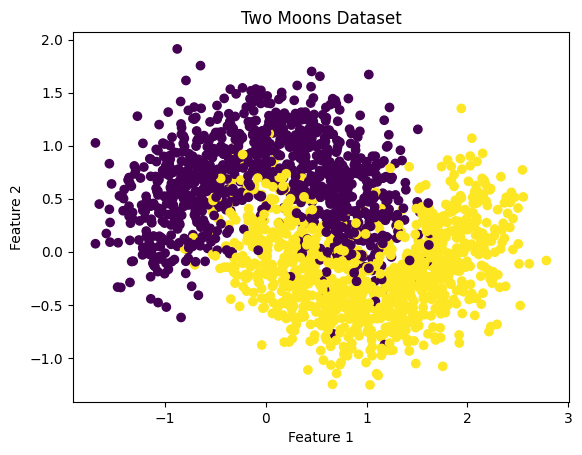

In [ ]:
# Lets view the data
plt.scatter(data["X1"], data["X2"], c=data["Y"])
plt.title("Two Moons Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [ ]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("Training features shape : ", x_train.shape)
print("Training lablels shape : ", y_train.shape)
print("Testing features shape : ", x_test.shape)
print("Testing labels shape : ", y_test.shape)

# standardization
scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train)
x_test_std = scaler.transform(x_test)

Training features shape :  (1600, 2)
Training lablels shape :  (1600,)
Testing features shape :  (400, 2)
Testing labels shape :  (400,)


In [ ]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device : ", device)

Device :  cuda


In [ ]:
# Model building : simple neural net with 2 hidden layers only
class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        layers = []
        current_size = input_size

        # Add hidden layers dynamically
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.ReLU())
            current_size = hidden_size

        # Output layer
        layers.append(nn.Linear(current_size, output_size))

        self.layer_stack = nn.Sequential(*layers)

    def forward(self, x):
        return self.layer_stack(x)

In [ ]:
# create accuracy function
def accuracy(y_true, y_pred):
    corrects = torch.eq(y_true, y_pred).sum().item()
    return (corrects / len(y_true)) * 100

In [ ]:
# create sigmoid function
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

In [ ]:
# Bring the data to tensor objects and to the same device
x_train = torch.from_numpy(x_train_std).type(torch.float).to(device)
x_test = torch.from_numpy(x_test_std).type(torch.float).to(device)
y_train = torch.from_numpy(y_train).type(torch.float).unsqueeze(1).to(device)
y_test = torch.from_numpy(y_test).type(torch.float).unsqueeze(1).to(device)
print(type(x_train), x_train.device)

<class 'torch.Tensor'> cuda:0


### Optuna
1. Simplicity: Extremely easy to integrate into custom PyTorch training loops with minimal boilerplate.
2. Efficiency: Implements advanced search algorithms like TPE (Tree-structured Parzen Estimator) for efficient hyperparameter exploration.
3. Lightweight: Focuses solely on optimization; has minimal dependencies.
4. Trial Pruning: Highly efficient pruning mechanism to terminate poor-performing trials early.
5. Visualization: Offers tools like parameter importance analysis and parallel coordinate plots.

In [ ]:
# Define the Optuna objective function
def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    n_hidden_layers = trial.suggest_int('n_hidden_layers', 1, 5)  # Between 1 and 5 hidden layers
    hidden_layer_sizes = [
        trial.suggest_int(f'layer_{i}_size', 8, 64, step=8) for i in range(n_hidden_layers)
    ]

    # Create the model
    torch.manual_seed(42)
    model = ClassificationModel(input_size=2, hidden_sizes=hidden_layer_sizes, output_size=1).to(device)

    # Choose optimizer
    optimizer_class = getattr(torch.optim, optimizer_name)
    optimizer = optimizer_class(model.parameters(), lr=lr)

    # Loss function
    loss_fn = nn.BCEWithLogitsLoss()

    # Training and testing loop
    epochs = 100
    for i in range(epochs):
        model.train()
        y_probs = model(x_train)
        y_preds = torch.round(sigmoid(y_probs))
        optimizer.zero_grad()
        train_loss = loss_fn(y_probs, y_train)
        train_acc = accuracy(y_train, y_preds)
        train_loss.backward()
        optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_probs = model(x_test)
        test_preds = torch.round(sigmoid(test_probs))

    val_acc = accuracy(y_test, test_preds)
    return val_acc

In [ ]:
# Run the Optuna study
study = optuna.create_study(direction='maximize')  # Minimize validation error
study.optimize(objective, n_trials=50)

[I 2024-12-14 14:31:39,634] A new study created in memory with name: no-name-4e92a8e2-ac18-46a7-b658-b7547c32e94f
[I 2024-12-14 14:31:50,210] Trial 0 finished with value: 64.5 and parameters: {'lr': 4.0606835939246126e-05, 'optimizer': 'SGD', 'n_hidden_layers': 1, 'layer_0_size': 48}. Best is trial 0 with value: 64.5.
[I 2024-12-14 14:31:50,964] Trial 1 finished with value: 50.74999999999999 and parameters: {'lr': 2.7299509052065682e-05, 'optimizer': 'Adam', 'n_hidden_layers': 4, 'layer_0_size': 24, 'layer_1_size': 16, 'layer_2_size': 32, 'layer_3_size': 48}. Best is trial 0 with value: 64.5.
[I 2024-12-14 14:31:51,318] Trial 2 finished with value: 71.75 and parameters: {'lr': 0.0005472988833879789, 'optimizer': 'SGD', 'n_hidden_layers': 2, 'layer_0_size': 16, 'layer_1_size': 64}. Best is trial 2 with value: 71.75.
[I 2024-12-14 14:31:51,610] Trial 3 finished with value: 49.25 and parameters: {'lr': 7.122979352080707e-05, 'optimizer': 'Adam', 'n_hidden_layers': 2, 'layer_0_size': 32, '

In [ ]:
print("Best hyperparameters:", study.best_params)

Best hyperparameters: {'lr': 0.0026331952660593144, 'optimizer': 'Adam', 'n_hidden_layers': 2, 'layer_0_size': 56, 'layer_1_size': 48}


In [ ]:
# Lets create the model with these specs and optimizer
model = ClassificationModel(2, [56, 48], 1).to(device)
print(model)

ClassificationModel(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=56, bias=True)
    (1): ReLU()
    (2): Linear(in_features=56, out_features=48, bias=True)
    (3): ReLU()
    (4): Linear(in_features=48, out_features=1, bias=True)
  )
)


In [ ]:
# loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.002)

In [ ]:
# Training and Testing Loop
torch.manual_seed(42)
epochs = 1000
for i in range(epochs):
    model.train()
    y_probs = model(x_train)
    y_preds = torch.round(sigmoid(y_probs))
    optimizer.zero_grad()
    train_loss = loss_fn(y_probs, y_train)
    train_acc = accuracy(y_train, y_preds)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_probs = model(x_test)
        test_preds = torch.round(sigmoid(test_probs))
        test_loss = loss_fn(test_probs, y_test)
        test_acc = accuracy(y_test, test_preds)

        if i % 100 == 0:
            print(f"Epoch {i} | Train Loss : {train_loss} and Train Acc. {train_acc} | Test Loss {test_loss} and Test Acc. {test_acc}")


Epoch 0 | Train Loss : 0.6553794741630554 and Train Acc. 50.4375 | Test Loss 0.638643205165863 and Test Acc. 72.5
Epoch 100 | Train Loss : 0.23924686014652252 and Train Acc. 91.0 | Test Loss 0.24895092844963074 and Test Acc. 90.5
Epoch 200 | Train Loss : 0.19848082959651947 and Train Acc. 92.3125 | Test Loss 0.2334524542093277 and Test Acc. 89.75
Epoch 300 | Train Loss : 0.19548535346984863 and Train Acc. 92.3125 | Test Loss 0.23781314492225647 and Test Acc. 90.0
Epoch 400 | Train Loss : 0.19383665919303894 and Train Acc. 92.5625 | Test Loss 0.23893027007579803 and Test Acc. 90.0
Epoch 500 | Train Loss : 0.19179023802280426 and Train Acc. 92.5 | Test Loss 0.2413852959871292 and Test Acc. 90.5
Epoch 600 | Train Loss : 0.18921424448490143 and Train Acc. 92.8125 | Test Loss 0.24463336169719696 and Test Acc. 90.5
Epoch 700 | Train Loss : 0.187210351228714 and Train Acc. 92.9375 | Test Loss 0.24774187803268433 and Test Acc. 90.25
Epoch 800 | Train Loss : 0.18564577400684357 and Train Acc. 9

In [ ]:
# Lets evaluate
model.eval()
with torch.inference_mode():
    test_probs = model(x_test)
    test_preds = torch.round(sigmoid(test_probs))
print(y_test[:5].squeeze())
print(test_preds[:5].squeeze())

tensor([1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0., 1., 1.], device='cuda:0')


In [ ]:
def plot_decision_boundary(model, X, y, resolution=0.01, device='cpu'):
    """
    Plots the decision boundary of a PyTorch classification model.

    Args:
        model: PyTorch model to evaluate.
        X (torch.Tensor): Input data (features), should be 2D with shape (n_samples, 2).
        y (torch.Tensor): True labels (n_samples,).
        resolution (float): Grid resolution for plotting.
        device (str): Device ('cpu' or 'cuda') where the model is located.
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Move data and model to the specified device
    X = X.to(device)
    y = y.to(device)
    model.to(device)

    # Define the grid for plotting
    x_min, x_max = X[:, 0].min().item() - 0.5, X[:, 0].max().item() + 0.5
    y_min, y_max = X[:, 1].min().item() - 0.5, X[:, 1].max().item() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    # Prepare grid points as input to the model
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)

    # Predict probabilities for the grid points
    with torch.no_grad():
        predictions = model(grid)
        if predictions.shape[1] > 1:  # Multi-class classification
            Z = torch.argmax(predictions, axis=1).cpu().numpy()
        else:  # Binary classification (single output)
            Z = (torch.sigmoid(predictions).cpu().numpy() > 0.5).astype(int).ravel()

    # Reshape predictions back to the grid shape
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=y.cpu(), edgecolor='k', cmap=plt.cm.Paired)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.show()

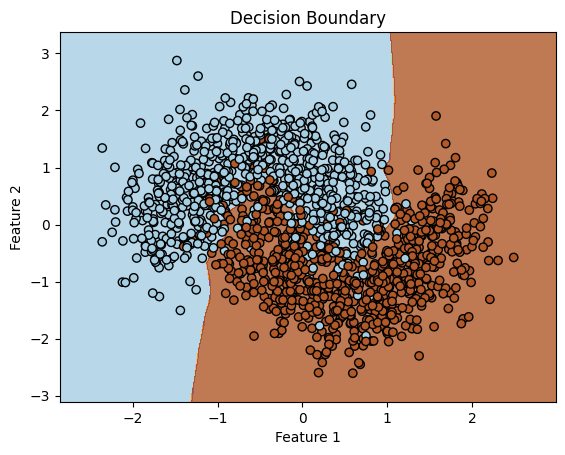

In [ ]:
plot_decision_boundary(model, x_train, y_train)

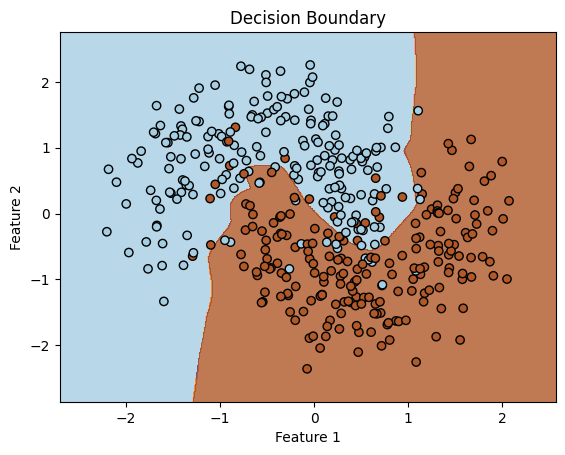

In [ ]:
plot_decision_boundary(model, x_test, y_test)

Nice Decision boundary btw !!